In [1]:
import json
import os
import pickle


from implicit.nearest_neighbours import ItemItemRecommender, BM25Recommender, TFIDFRecommender, bm25_weight
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoost

RAW_DATA_PATH = './raw_data/'
DATA_PATH = './data'
RANDOM_STATE = 42
TOP_N = 100

# Data

In [2]:
test_users = pd.read_csv(os.path.join(RAW_DATA_PATH, 'test_users.csv'))

In [3]:
val1_pairs = pd.read_hdf(os.path.join(DATA_PATH, 'step4_val1_pairs.h5'), key='step4', mode='r')
val2_pairs = pd.read_hdf(os.path.join(DATA_PATH, 'step4_val2_pairs.h5'), key='step4', mode='r')
test_pairs = pd.read_hdf(os.path.join(DATA_PATH, 'step4_test_pairs.h5'), key='step4', mode='r')

In [4]:
tmp = (
    val1_pairs
        .groupby('user_id')
        .apply(lambda df: df.sort_values('clicks_als_score', ascending=False).head(1023))
        .index.get_level_values(1)
)
print(val1_pairs.shape)
val1_pairs = val1_pairs.iloc[tmp]
print(val1_pairs.shape)

(16022162, 18)
(8195253, 18)


In [5]:
tmp = (
    val2_pairs
        .groupby('user_id')
        .apply(lambda df: df.sort_values('clicks_als_score', ascending=False).head(1023))
        .index.get_level_values(1)
)
print(val2_pairs.shape)
val2_pairs = val2_pairs.iloc[tmp]
print(val2_pairs.shape)

(16056153, 18)
(8212644, 18)


In [6]:
tmp = (
    test_pairs
        .groupby('user_id')
        .apply(lambda df: df.sort_values('clicks_als_score', ascending=False).head(1023))
        .index.get_level_values(1)
)
print(test_pairs.shape)
test_pairs = test_pairs.iloc[tmp]
print(test_pairs.shape)

(2760000, 17)
(1411740, 17)


In [7]:
use_features = test_pairs.columns.tolist()
use_features

['picture_id',
 'user_id',
 'clicks_als_score',
 'user_emb_0',
 'user_emb_1',
 'user_emb_2',
 'user_emb_3',
 'user_emb_4',
 'user_emb_5',
 'user_emb_6',
 'user_emb_7',
 'user_emb_8',
 'user_emb_9',
 'user_emb_10',
 'user_emb_11',
 'user_emb_12',
 'themes']

In [8]:
use_features  = [
    'picture_id',
    'user_id',
    'clicks_als_score',
    'themes',
#     'user_emb_0',
#     'user_emb_1',
#     'user_emb_2',
#     'user_emb_3',
#     'user_emb_4',
#     'user_emb_5',
#     'user_emb_6',
#     'user_emb_7',
#     'user_emb_8',
#     'user_emb_9',
#     'user_emb_10',
#     'user_emb_11',
#     'user_emb_12'
]

# Подготовка

In [9]:
val1_users = val1_pairs['user_id'].unique()
val2_users = val2_pairs['user_id'].unique()
train1_users, holdout1_users = train_test_split(val1_users, test_size=0.2, shuffle=True, random_state=7)
train2_users, holdout2_users = train_test_split(val2_users, test_size=0.2, shuffle=True, random_state=7)

train_pairs = pd.concat(
    [val1_pairs.query('user_id in @train1_users'), val2_pairs.query('user_id in @train2_users')],
    ignore_index=True
)

holdout_pairs = pd.concat(
    [val1_pairs.query('user_id in @holdout1_users'), val2_pairs.query('user_id in @holdout2_users')],
    ignore_index=True
)

train_pairs = train_pairs.sort_values('user_id')
holdout_pairs = holdout_pairs.sort_values('user_id')

In [61]:
sp.csr_matrix(train_pairs[use_features])

<13125090x3 sparse matrix of type '<class 'numpy.float64'>'
	with 39375270 stored elements in Compressed Sparse Row format>

In [10]:
from catboost import Pool

train = Pool(
    data=train_pairs[use_features],
    label=train_pairs['y'],
    group_id=train_pairs['user_id'].values,
#    group_weight=train_pairs['user_weight'].values.astype(np.float64),
#     cat_features=np.arange(len(use_features) - len(cat_features), len(use_features))
)

test = Pool(
    data=holdout_pairs[use_features],
    label=holdout_pairs['y'],
    group_id=holdout_pairs['user_id'],
#    group_weight=holdout_pairs['user_weight'].values.astype(np.float64),
#     cat_features=np.arange(len(use_features) - len(cat_features), len(use_features))
)

CatBoostError: Bad value for num_feature[306,3]="3 18": Cannot convert 'b'3 18'' to float

In [63]:
# del train_pairs
# del holdout_pairs

# Обучение

In [11]:
%matplotlib notebook

params = {
    'loss_function': 'YetiRank', # 'Logloss',
    'learning_rate': 3, # 0.01, # # 0.1
    'depth': 9, 
    'l2_leaf_reg': 10, 
    'n_estimators': 1000, # 10000
    'random_state': RANDOM_STATE,
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'thread_count': 8,
    'task_type': 'GPU',
    'devices': '0:1',
    'one_hot_max_size': 50,
    
#     'custom_metric': ['MAP:top=20', 'RecallAt:top=20'],
#     'eval_metric': ['MAP:top=20'],

    ######################
#     'max_bin': 128,
#     'grow-policy': 'SymmetricTree',
#     'min_data_in_leaf': 1, # Lossguide and Depthwise
#     'max_leaves': 31 # Lossguide 
}

model = CatBoost(params)
model.fit(train, eval_set=test, plot=False, verbose=10)

NameError: name 'train' is not defined

In [ ]:
#  0.003399450059

# 0.00074911414 ?

# 0.0004065 (Log)


# ~0.00337 (3)
# 0.0033596 (1)

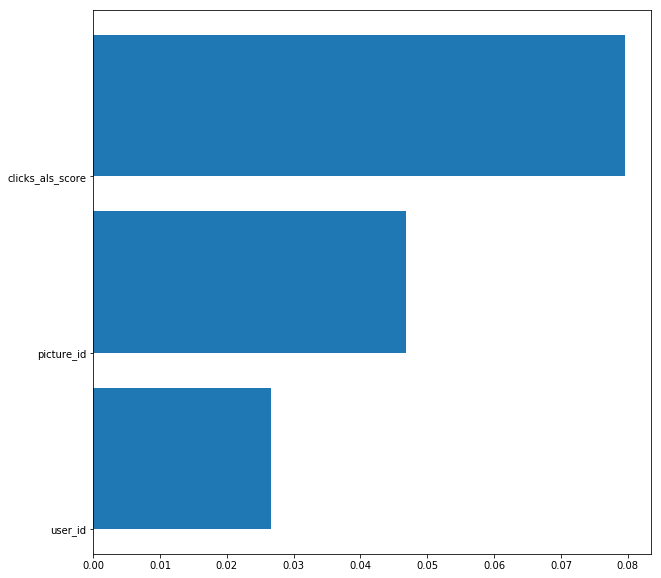

In [93]:
%matplotlib inline

importances = pd.DataFrame(model.get_feature_importance(train), index=model.feature_names_).sort_values(0, ascending=True)
plt.figure(figsize=(10, 10))
plt.barh(importances.index, importances[0], align='edge')
plt.show()

In [48]:
test_pairs.values

array([[1.01795700e+06, 1.03000000e+02, 1.10528183e+00, ...,
                   nan,            nan,            nan],
       [1.01582500e+06, 1.03000000e+02, 1.01722622e+00, ...,
                   nan,            nan,            nan],
       [1.01585300e+06, 1.03000000e+02, 9.84761000e-01, ...,
                   nan,            nan,            nan],
       ...,
       [1.16446600e+06, 4.99544000e+05, 2.72129034e-03, ...,
        5.81864471e-02, 4.21065125e-02, 3.11176530e-03],
       [1.00948300e+06, 4.99544000e+05, 2.72096973e-03, ...,
        5.81864471e-02, 4.21065125e-02, 3.11176530e-03],
       [1.29394700e+06, 4.99544000e+05, 2.72090407e-03, ...,
        5.81864471e-02, 4.21065125e-02, 3.11176530e-03]])

In [66]:
test_pairs['prob'] = model.predict(
    test_pairs.values, 
#     test_pairs[model.feature_names_], 
    verbose=True,
    thread_count = 8,
    prediction_type='Probability'
)[:, 1]

In [50]:
test_pairs

,picture_id,user_id,clicks_als_score,user_emb_0,user_emb_1,user_emb_2,user_emb_3,user_emb_4,user_emb_5,user_emb_6,user_emb_7,user_emb_8,user_emb_9,user_emb_10,user_emb_11,user_emb_12,prob
75039,1017957,103,1.105282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.707826
74007,1015825,103,1.017226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693254
74026,1015853,103,0.984761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.707826
74916,1312605,103,0.906608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.937603
75470,625632,103,0.876520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.532449
74230,1253832,103,0.874248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878806
75761,1293806,103,0.821155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.913326
74751,972323,103,0.808736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633974
74572,1254515,103,0.783066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878806
75928,1150808,103,0.723197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875551


In [110]:
# tmp = (
#     test_pairs
#         .groupby('user_id')
#         .apply(lambda df: df.sort_values('clicks_als_score', ascending=False).head(1000))
#         .index.get_level_values(1)
# )
# print(test_pairs.shape)
# tmp_test_pairs = test_pairs.loc[tmp]
# print(tmp_test_pairs.shape)
# 
# tmp_test_pairs = tmp_test_pairs.drop('prob', axis=1).rename({'clicks_als_score': 'prob'}, axis=1)

(1411740, 4)
(1380000, 4)


In [67]:
result = (
    test_pairs # tmp_test_pairs 
    .sort_values(['user_id', 'prob'], ascending=[True, False])
    .groupby('user_id')['picture_id']
    .apply(lambda x: x.values[:TOP_N].tolist())
)

In [68]:
print(len(result))
for k, v in result.items():
    if len(v) != TOP_N:
        print(k)

1380


In [53]:
result

user_id
103       [1318205, 1318200, 1318810, 1319853, 1318095, ...
178       [192862, 159160, 151920, 216057, 157388, 16437...
1069      [1431415, 1410309, 1431355, 1429366, 1431028, ...
1310      [1464651, 1461622, 1449065, 1452733, 1431415, ...
2108      [167224, 213919, 197184, 189122, 192461, 17885...
2272      [1434391, 1438193, 1375123, 1424036, 1424105, ...
2474      [129023, 28148, 1478890, 1478726, 99475, 10214...
2501      [1483070, 1483146, 1483051, 1483485, 1483085, ...
2594      [1431415, 1434045, 1413419, 1415889, 1411426, ...
2896      [1484688, 1468070, 1468784, 1462840, 1464095, ...
2979      [148273, 164781, 176025, 169017, 148113, 15783...
3368      [1465530, 1452596, 1448216, 1448487, 1451665, ...
3497      [1120446, 1106272, 1120884, 1121216, 1110928, ...
3708      [1461242, 1444796, 1444656, 1457625, 1456917, ...
3731      [1481039, 1448216, 1457214, 1394434, 1395288, ...
4077      [1448216, 1484441, 1212444, 1478890, 1478726, ...
4168      [129023, 129022, 17698

In [100]:
!cat baseline_predictions.csv

user_id,predictions
103,1108557 1045805 1108662 1259132 1317683 1167421 1171232 1177402 1259222 288808 1340963 1266494 1265517 1197775 1317529 1171236 1108318 1318200 1263320 235622 1108572 1108199 1264605 1342985 1418564 1298025 1323330 1247642 1137668 1108542 894410 1259131 1137623 1231874 1304457 1168443 1192713 1259243 1358800 1323344 997617 1108546 1341262 1317656 1255925 1154184 918587 799040 1323751 1259127 1344429 949143 1134340 1323325 1144186 1105254 1340063 1323815 1341314 1323138 1265469 1037656 670911 792571 1317685 1323227 1217842 1317551 1110751 1344384 1135821 884248 1184281 1309484 1268831 1328109 997582 992226 1108566 1317585 1228445 1118631 1060889 996475 1191525 1344355 1024565 695050 1086093 1337797 996766 1288520 1323336 670066 1253566 1086825 1336588 1267830 1108200 1229201
178,1106272 1183022 1351800 1065561 1100170 1385945 1382409 1382415 1440878 1423543 1231874 1426486 1392426 1440871 1439908 1439350 1476362 1452596 1401005 1002876 1118959 1441383 1277899 1420

251720,288808 1259132 1004627 925933 1258766 1191525 1171232 1061085 987619 1147108 943038 1111904 1063049 1249833 1069235 971275 1259222 1016796 1167421 1302478 1195825 1087749 1120561 920912 1317683 1265517 1263005 928752 1238566 1431415 1268915 1209829 1279510 1263320 811053 812190 903290 1242260 1151268 1253832 1258358 1413752 1348108 1339375 1283054 1376565 1255526 1330467 809961 1022034 1363371 1249286 985657 1088236 1045805 1262904 1042279 957734 1076214 1251338 1055967 1348121 1314594 1258679 1171236 1258721 1330583 1413419 988032 1105427 1333003 1287108 1314709 972615 936996 922315 1076232 879747 1088269 1025775 1108557 1398926 971271 1167420 1330107 1217842 1094661 918940 1015851 1253863 846321 876217 1307162 1091426 1358800 1067834 1251715 1415889 1321389 1420421
252609,1183022 1343195 901311 1191506 1092132 1232391 1307056 282833 1234034 1285813 1134673 1285815 1299404 1354089 1299402 1338617 1385945 1252513 1106519 1382409 1067817 1382415 1440878 1309582 1423543 1065561 14

487482,1004627 288808 1291740 925933 1259132 1278935 1258766 1191525 1147108 943038 1063049 1061085 987619 1258695 1111904 1069235 971275 1120561 1302478 1087749 920912 1263005 1268915 1171232 812190 1249833 811053 1431415 1279510 903290 1238566 1376565 1209829 1265517 1151268 1413752 1258358 1283054 1255526 1314594 1314709 1262904 1259222 1167421 928752 1330467 1253832 1317683 1076232 1249286 985657 1251338 1413419 1076214 1025775 1348108 1363371 971271 1088236 1022034 1277084 972615 918940 1088269 1094661 1330107 936996 1042279 1398926 1307162 1167420 922315 1415889 809961 957734 1330583 1067834 876217 1263320 275624 1253863 1091426 1015851 1351709 1105254 1348121 1339375 1055967 1367604 260066 1097781 1094669 1293138 926484 1231307 846321 1346391 988032 1159212 1023469
488179,1247642 1358800 792571 1329973 747157 1268831 1249468 1255925 1310011 1164346 1328109 1275577 1171232 1233569 1263297 1278330 1310025 1259132 1197775 1275117 1045805 1057325 949143 235622 1336252 1224995 125905

In [69]:
new_result = pd.DataFrame(
    result.apply(lambda x: ' '.join(map(str, x))).reset_index(),
)
new_result.columns=['user_id', 'predictions']
new_result

,user_id,predictions
0,103,1462900 1481039 1457214 1448216 1233363 123383...
1,178,192862 235622 216057 223747 159160 151920 1573...
2,1069,1464651 1464599 1481344 1431415 1238566 124226...
3,1310,1464651 1461622 1452733 1449065 1464216 146422...
4,2108,213919 167224 197184 189122 192461 178850 2009...
5,2272,1434391 1460093 1070717 1431415 1434339 143892...
6,2474,1478890 1478726 1477490 1476836 129023 1431800...
7,2501,1483070 1483146 1483051 1483485 1483085 148325...
8,2594,1452733 1434045 1431415 282985 1415889 1436195...
9,2896,1468070 1468784 1462840 1464095 1464079 146937...


In [70]:
assert len(new_result['user_id'] & test_users['user_id']) == test_users['user_id'].shape[0]

In [71]:
import datetime
dt = datetime.datetime.strftime(datetime.datetime.now(), '%Y.%m.%d_%H.%M.%S')
new_result.to_csv('{}_500_catboost_yeti_answer.csv'.format(dt), index=False)

In [57]:
!cat 2019.06.02_06.15.45_catboost_answer.csv

user_id,predictions
103,1017957 1015825 1015853 1312605 625632 1253832 1293806 972323 1254515 1150808 1328916 1337968 1253846 1337965 882349 965911 1015851 982741 1344278 1313836 622670 1015856 1337797 1337963 1156576 625593 1015860 1257369 1088220 1011358 1329305 1367417 1045622 625951 553354 1343393 919538 1017958 625984 361939 1294473 1041188 138191 1075462 1015841 1041187 626062 625422 625640 1182995 1371207 1121185 1121181 1367105 625976 515840 1250751 1337962 1252336 1369387 1367404 1047614 1015850 1169165 1253842 1259944 625615 1046085 1108199 1078014 949143 625582 803256 1371820 1044402 1360092 1367420 90723 1332111 1075436 1333589 1075473 81520 1267182 761221 1337959 1255403 1065295 329396 911571 1127217 1088226 956497 996384 1072628 622630 1367363 1156496 526239 625931
178,1420421 235622 1329593 1065561 1343195 1177402 1354089 1266494 1134673 1436637 1273575 1300437 1184348 1418564 1424214 1290755 880793 996750 1290793 1293465 1287976 1159315 1029461 1303703 1220665 1172293 1

213950,1258763 1004627 1291740 1069235 903290 1413752 1016796 971275 1415889 282985 1120561 982902 811053 1293947 925933 515625 1077015 1198235 1376565 1063049 1299548 1025775 846325 1167420 1023469 1249286 1314594 943038 1042279 1087771 1398926 1348108 1262904 515622 1088236 1413419 1258695 1353497 1346388 1394032 800529 1243382 999630 1284840 1330107 1253839 1320664 1364260 1285810 1478344 1264211 1314302 1340866 1266455 921870 1061085 1120446 1145507 969143 1087749 929755 920912 1262104 1278935 1258358 1249273 1285813 135244 1285815 1005853 1147108 1370036 1203688 1401756 1215242 1278942 1251338 515620 1067834 812190 972616 1354879 1092132 1258762 876217 1228321 1378278 1123262 1414767 1370475 637481 922315 1195849 1258766 926484 283088 1094661 1263320 1346394 1195841
214050,920304 1081973 483993 632918 1119651 1194858 1062869 1235406 894550 1112611 1461508 1313266 150206 1453586 613478 193192 1429854 483977 1099080 244821 1259503 1391162 1364677 557911 796591 1252903 927072 343247 

445882,216101 187377 216117 145555 260066 167224 167803 145554 233839 275624 272107 215461 187405 233998 145550 201103 201268 167804 186989 187407 233836 1257349 1206415 167875 234038 214004 1020243 201398 1106282 376200 233994 216132 166354 167051 288808 201600 260109 201403 216060 1256228 383798 1098838 272143 221008 1259132 318139 799994 233992 167799 216058 1290503 1052147 166355 1111311 216113 166784 1163234 1082732 1274216 1410309 233835 1007146 234016 1279223 648794 145529 1385512 1434045 145715 1260878 1215934 120101 288180 267215 166938 233850 201608 166788 1297984 1070747 313538 1307098 267202 1305138 234003 958048 1229798 1317853 334247 1338440 1294310 1057092 1348532 1387265 1277903 234000 412212 1264211 501324 1152832
446301,1106519 1477490 1476836 1212444 990139 1478890 1179559 1320245 1478726 1142703 1418564 1430141 1092132 1296221 1402487 1222847 1467448 1478690 1292393 282985 1407213 1298491 1258819 1343758 1368754 283088 1290755 288808 1348945 515625 1368369 319273 14

In [124]:
!wc -l baseline_predictions.csv

1381 baseline_predictions.csv


In [125]:
!wc -l 2019.06.02_06.15.45_catboost_answer.csv

1381 2019.06.02_06.15.45_catboost_answer.csv
